In [66]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats import descriptivestats

In [67]:
results = Result.objects.filter(n_tiles=20)

In [68]:
results.values('score')

<QuerySet [{'score': 3.0}, {'score': 3.0}, {'score': 2.0}, {'score': 1.0}, {'score': 1.0}, {'score': 2.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 1.0}, {'score': 4.0}, {'score': 2.0}, {'score': 1.0}, {'score': 1.0}, {'score': 4.0}, {'score': 3.0}, {'score': 3.0}, {'score': 0.0}, {'score': 5.0}, {'score': 1.0}, '...(remaining elements truncated)...']>

In [84]:
def calc_p_value(results, max_depth_instances, avg_depth_instances): 
    max_depth_wins = 0
    avg_depth_wins = 0
    draws = 0
    values = []
    for max_depth_res in max_depth_instances:
        avg_depth_res = results.filter(
            score__isnull=False, strategy='avg_depth',
            cols=max_depth_res.cols, rows=max_depth_res.rows,
            tiles=max_depth_res.tiles, **common_args)
        
        if avg_depth_res.count() == 1:
            avg_depth_score = avg_depth_res.first().score
            max_depth_score = max_depth_res.score
            if avg_depth_score > max_depth_score: # lower is better
                max_depth_wins +=1 
                values.append(1)
            elif avg_depth_score < max_depth_score:
                avg_depth_wins += 1
                values.append(-1)
            else:
                draws += 1
                
    print(f'In total max_depth_wins: {max_depth_wins}, avg_depth_wins: {avg_depth_wins}, and {draws} ties.')
    
    m = descriptivestats.sign_test(values)
    print(f'p value: {m[1]}')

In [85]:

common_args = {'problem_generator': 'florian', 'n_simulations': 1000}

common_args['problem_generator'] = 'guillotine'


# find same problem instances
avg_depth_ids = []
max_depth_ids = []
for max_depth_res in results.filter(score__isnull=False, strategy='max_depth', **common_args):
    avg_depth_score = results.filter(
        score__isnull=False, strategy='avg_depth',
        cols=max_depth_res.cols, rows=max_depth_res.rows,
         tiles=max_depth_res.tiles, **common_args)
    if avg_depth_score:
        avg_depth_ids.append(avg_depth_score.first().id)
        max_depth_ids.append(max_depth_res.id)
g_max_depth_instances = results.filter(id__in=max_depth_ids)
g_avg_depth_instances = results.filter(id__in=avg_depth_ids)
g_max_depth_scores = g_max_depth_instances.values('score')
g_avg_depth_scores = g_avg_depth_instances.values('score')

print('Guillotine')
calc_p_value(Result.objects.filter(**common_args), g_max_depth_instances, g_avg_depth_instances)

common_args['problem_generator'] = 'florian'
ng_avg_depth_instances = results.filter(score__isnull=False, strategy='avg_depth', **common_args)
ng_max_depth_instances = results.filter(score__isnull=False, strategy='max_depth', **common_args)
ng_avg_depth_scores = ng_avg_depth_instances.values('score')
ng_max_depth_scores = ng_max_depth_instances.values('score')
    
print('Non-guillotine')
calc_p_value(Result.objects.filter(**common_args), ng_max_depth_instances, ng_avg_depth_instances)

print(g_avg_depth_scores.count())
print(g_max_depth_scores.count())

print(ng_avg_depth_scores.count())
print(ng_max_depth_scores.count())

# scores = results.values('score', 'strategy')
# print(np.average(np.array(results.filter(score__isnull=False, strategy='avg_depth', **common_args).values_list('rows', flat=True))))
# print(np.average(np.array(results.filter(score__isnull=False, strategy='max_depth', **common_args).values_list('rows', flat=True))))

Guillotine
In total max_depth_wins: 25, avg_depth_wins: 5, and 10 ties.
p value: 0.0003249142318964004
Non-guillotine
In total max_depth_wins: 938, avg_depth_wins: 86, and 148 ties.
p value: 9.869312967488662e-182
39
41
1172
1172


In [30]:
scores_df = pd.DataFrame.from_records(scores)
avg_depth_df = pd.DataFrame.from_records(avg_depth_scores)
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

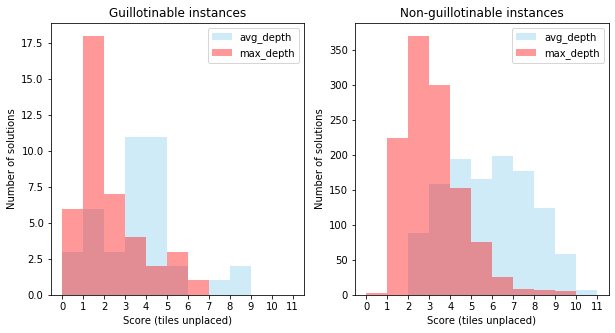

In [46]:
# scores_df
f, axes = plt.subplots(1, 2)

bins = np.arange(0, 12)
for i in range(2):
    if i == 0:
        title = 'Guillotinable instances'
        avg_depth_scores = g_avg_depth_scores
        max_depth_scores = g_max_depth_scores
    else:
        title = 'Non-guillotinable instances'
        avg_depth_scores = ng_avg_depth_scores
        max_depth_scores = ng_max_depth_scores
        
    sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)),
                 kde=False, color='skyblue', label='avg_depth', bins=bins, ax=axes[i])
    sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)),
                      kde=False, color='red', label='max_depth', bins=bins, ax=axes[i])
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axes[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    # plt.xlim(left=i)
    axes[i].set_ylabel('Number of solutions')
    axes[i].set_xlabel('Score (tiles unplaced)')
    axes[i].set_title(title)
    axes[i].legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

In [7]:
# find total scores by annotation
from django.db.models import Count
results.values('score').annotate(total_for_score=Count('score'))

<QuerySet [{'score': 5.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 4.0, 'total_for_score': 1}, {'score': 7.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 1.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 1.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 3.0, 'total_for_score': 1}, {'score': 0.0, 'total_for_score': 1}, {'score': 2.0, 'total_for_score': 1}, '...(remaining elements truncated)...']>

In [8]:
results.count()

2458

### Simulation runs vs score

In [9]:
s1 = set(Result.objects.filter(n_simulations=5000).values_list('their_id', flat=True))
s2 = set(Result.objects.filter(n_simulations=10000).values_list('their_id', flat=True))
s1 - s2
Result.objects.filter(n_simulations=10000)

<QuerySet []>

<QuerySet [1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 3.0, 1.0, 1.0]>
<QuerySet [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]>
<QuerySet [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]>
<QuerySet [0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]>
<QuerySet [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0]>
Number of tiles non-placed in correlation with simulation runs


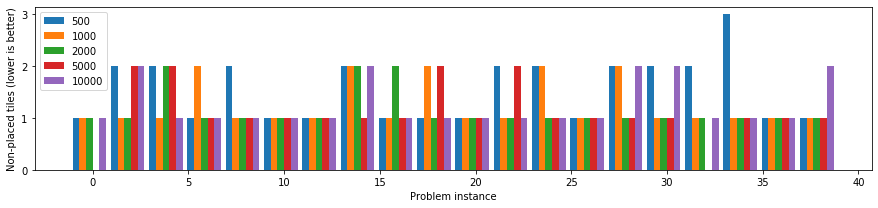

In [71]:
from collections import defaultdict
SIMULATION_RUNS = [500, 1000, 2000, 5000, 10000]
problem_ids = Result.objects.filter(n_simulations=5000).order_by('their_id').values_list('their_id', flat=True)
x_vals = defaultdict(list)
results = {}

plt.rcParams["figure.figsize"] = (15,3)

for n_simulations in SIMULATION_RUNS:
    s1 = Result.objects.filter(
        their_id__in=problem_ids,
        strategy='max_depth',
        n_simulations=n_simulations).order_by('their_id').values_list('score', flat=True)
    results[n_simulations] = s1
    
fig = plt.figure()
x = np.arange(0, len(problem_ids)* 2, 2)
y = np.arange(0,3)
width_offset = 0.35
width = - width_offset * 2.5 
for n_simulations, result in results.items():
    print(result)
    plt.bar(x + width, result, width=width_offset, label=n_simulations)
    width += width_offset
   
plt.yticks(ticks=np.arange(0, 4))
plt.xlabel('Problem instance')
plt.ylabel('Non-placed tiles (lower is better)')
plt.legend()
print('Number of tiles non-placed in correlation with simulation runs')
plt.show()

### Tiles placed (Huristic vs MCTS)

In [14]:
instances_where_solution_is_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian').values('n_tiles_placed', 'their_tiles_placed')
scores_df = pd.DataFrame.from_records(instances_where_solution_is_found)
scores_df

,n_tiles_placed,their_tiles_placed
0,858933,29007
1,962642,22
2,843695,77


In [11]:
solutions_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='florian', n_simulations=1000).count()
solutions_not_found = Result.objects.filter(solution_found=False, n_tiles=20, problem_generator='florian', n_simulations=1000).count()
print('Florian instances')
print(f'solutions found: {solutions_found} \nsolutions not found: {solutions_not_found}')
print(f'perc: {solutions_found / solutions_not_found * 100} %')

Florian instances
solutions found: 3 
solutions not found: 402
perc: 0.7462686567164178 %


In [10]:
print('Guillotine instances')
solutions_found = Result.objects.filter(solution_found=True, n_tiles=20, problem_generator='guillotine', n_simulations=1000).count()
solutions_not_found = Result.objects.filter(solution_found=False, n_tiles=20, problem_generator='guillotine', n_simulations=1000).count()
print(f'solutions found: {solutions_found} \nsolutions not found: {solutions_not_found}')
print(f'perc: {solutions_found / solutions_not_found * 100} %')

Guillotine instances
solutions found: 58 
solutions not found: 94
perc: 61.702127659574465 %
